In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SK learn stuff
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
	"axes",
	labelweight="bold",
	labelsize="large",
	titleweight="bold",
	titlesize=14,
	titlepad=10,
)

# Utility functions from the Kaggle Tutorials
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

def fix_null_cols(X):
    # before we can do that we have to find and fix some null values showing up in numeric columns
    numeric_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

    null_col_sums = [X[i].isnull().sum() for i in numeric_cols]
    null_cols = [numeric_cols[i] for i in range(len(numeric_cols)) if null_col_sums[i] > 0]

    X_fixed = X[null_cols].fillna(value=0, inplace=False)
    X[null_cols] = X_fixed
    return X

def get_MAE_score(X, y): 
    baseline_regressor = RandomForestRegressor(criterion="mae", random_state=0)
    X = pd.get_dummies(X)
    score = cross_val_score(baseline_regressor, X, y, cv=5, scoring="neg_mean_absolute_error").mean() * -1

    return score


In [22]:
# read in the data
df = pd.read_csv('data/train.csv', index_col=0)
df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [47]:
# let's first find a baseline score for this data, so we can see if we can improve it
X = df.copy()
y = X.pop("SalePrice")

X = fix_null_cols(X)



In [48]:
# let's setup and score a basic model
score = get_MAE_score(X, y)
print(f"base MAE score with nothing modified other than dummies for categoricals: {score:.4f}")

base MAE score with nothing modified other than dummies for categoricals: 17767.6703


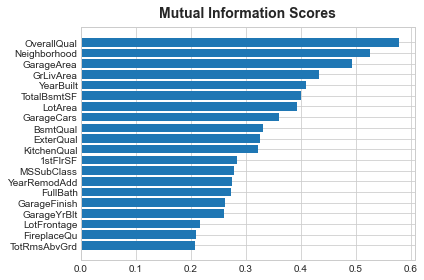

In [49]:
# first we are going to find the mutual information scores for our training data
X_mi = df.copy()
y_mi = X_mi.pop('SalePrice')
X_mi = fix_null_cols(X_mi)

mi_scores = make_mi_scores(X_mi, y_mi)
plot_mi_scores(mi_scores.head(20))

In [50]:
# from what we can see, living space features almost all score quite well. an overall score of all interior living area may be beneficial to the model so we'll add that and see if it helps
X_mi['TotalInteriorSF'] = X_mi['GrLivArea'] + X_mi['TotalBsmtSF'] + X_mi['GarageArea']


In [51]:
score = get_MAE_score(X_mi, y_mi)
print(f"MAE score with compound living area feature: {score:.4f}")

MAE score with compound living area feature: 17169.5740


In [ ]:
X_mi["MedNhbdArea"] = X_mi.groupby("Neighborhood")["GrLivArea"].transform("median")